<a href="https://colab.research.google.com/github/shuuuuyu/114-1-Programing-Language/blob/main/hw_4_%E6%96%87%E5%AD%97%E8%B3%87%E6%96%99%E5%B0%8F%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 晉江文學城月榜智能分析系統

## 📝 專案說明

本專案旨在爬取晉江文學城的月票榜，分析當前最受歡迎的小說趨勢，幫助作者了解讀者偏好，進行內容創作規劃或商業布局。

## ⚠️ 重要聲明

### 開發過程

**初期嘗試 (Gemini API)**
- 最初使用 Google Gemini API 進行簡介清理和分析
- 發現免費額度有限，處理 20-30 本小說後就會超出限額
- 測試發現直接分析原始簡介得到的熱詞不夠準確

**改進方案 (AI 清理簡介)**
- 為提升準確度，嘗試用 AI 先清理簡介，去除網站系統詞彙
- 再對清理後的簡介進行關鍵字分析
- 但 Gemini 版本因額度限制，往往分析到一半就無法繼續

**最終方案 (Groq API)**
- 改用 Groq API (Llama 3.3 70B 模型)
- **主要優勢：免費額度較多**，可完整處理更多小說的簡介
- 本專案主要使用此版本

### 技術限制與反思

經過多次測試和調整後，我發現分析結果不盡理想的**原因可能不在程式本身**，而是缺乏專業的**文字探勘技術**

雖然程式能成功爬取資料、清理文本、提取關鍵字，但提取出的「熱詞」往往缺乏實用性，無法有效反映真正的市場趨勢。這可能需要更深入的：
- 自然語言處理（NLP）技術
- 更精緻的停用詞過濾
- 進階的特徵工程
- 主題模型（如 LDA）
- 更專業的文本分析方法

## 🚀 功能特色

### 1. 完整爬蟲流程
- ✅ 自動爬取晉江月票榜前 N 名作品
- ✅ 提取書名、作者、類別、字數、簡介等資訊
- ✅ 自動寫入 Google Sheets，方便查看和分享

### 2. AI 智能清理
- ✅ 使用 **Groq API (Llama 3.3 70B)** 清理簡介
- ✅ 將原始簡介濃縮成 **30 字以內的核心要素**
- ✅ 自動過濾系統詞：「閱讀」「出版」「簽約」「霸王票」等
- ✅ 保留「原始簡介」和「清理後簡介」兩欄，方便對照

### 3. 關鍵字分析
- ✅ 使用 **sklearn TF-IDF** 提取關鍵字
- ✅ 擴充停用詞列表（80+ 無意義詞）
- ✅ 計算平均 TF-IDF 分數和詞頻
- ✅ 輸出前 50 個熱門關鍵字

### 4. AI 市場洞察
- ✅ 自動生成 5 條核心洞察
- ✅ 分析類別分布和市場趨勢
- ✅ 提供總結論和建議

### 5. Gradio 互動介面
- ✅ 友善的網頁介面，無需寫程式
- ✅ 可調整爬取數量和關鍵字數
- ✅ 即時顯示分析結果


## **設定 Colab Secrets**
   ```
   左側點擊 🔑 圖示
   新增 Secret：
   - Name: groq_test
   - Value: 您的 Groq API Key
   ```

## 📚 參考網站

- **晉江文學城**：https://www.jjwxc.net

## ⚖️ 免責聲明

1. 本專案僅供學習研究使用
2. 請遵守晉江文學城的使用條款
3. 爬取資料請適度，避免對網站造成負擔
4. 分析結果僅供參考，不保證準確性
5. 請勿用於商業用途或侵犯版權


### groq

In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
晉江文學網月榜智能分析系統 - Groq 清理簡介版
✅ 使用 Groq API (llama-3.3-70b-versatile) 清理簡介
✅ 過濾「一句話簡介」「立意」「正文」「全文」「練筆」等
✅ 將原始簡介和清理後簡介分別儲存
"""

# ==================== Step 1: 安裝依賴套件 ====================
print("📦 正在安裝依賴套件...")
import subprocess
import sys

packages = [
    'beautifulsoup4',
    'pandas',
    'requests',
    'scikit-learn',
    'jieba',
    'groq',
    'gradio',
    'gspread',
    'oauth2client'
]

for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("✅ 依賴套件安裝完成！\n")

# ==================== Step 2: 導入模組 ====================
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import jieba
import jieba.analyse
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
from groq import Groq
import gradio as gr
from datetime import datetime
import re
import os
from google.colab import auth
from google.auth import default
import gspread

# ==================== Step 3: 主程式類別 ====================
class JJWXCAnalyzer:
    """晉江文學網分析器 - Groq 清理簡介版"""

    def __init__(self, sheet_url, groq_api_key=None):
        self.sheet_url = sheet_url
        self.sheet_id = self._extract_sheet_id(sheet_url)
        self.base_url = 'https://www.jjwxc.net'
        self.session = self._setup_session()

        # Google Sheets 客戶端
        self.gc = None
        self.spreadsheet = None

        # Groq API
        if groq_api_key and groq_api_key.strip():
            try:
                self.groq_client = Groq(api_key=groq_api_key)
                print("✅ Groq API 已設定")
            except Exception as e:
                print(f"⚠️ Groq API 設定失敗: {e}")
                self.groq_client = None
        else:
            self.groq_client = None
            print("ℹ️ 未設定 Groq API")

        # ✅ 大幅擴充停用詞列表（加入您看到的所有無意義詞）
        self.stopwords = set([
            # 基本停用詞
            '的', '了', '是', '在', '我', '你', '他', '她', '之', '一個', '和', '有', '不',
            '也', '就', '都', '而', '及', '與', '或', '等', '著', '很', '要', '會', '沒',
            '到', '說', '去', '上', '下', '來', '過', '給', '把', '被', '從', '對', '為',
            '個', '這', '那', '些', '裡', '中', '時', '只', '但', '還', '自己', '什麼',
            '可以', '已經', '如果', '因為', '所以', '可能', '應該', '能夠', '經過',

            # 人稱代詞（擴充）
            '他們', '她們', '我們', '你們', '它們', '人們', '大家', '別人', '自己',
            '他的', '她的', '我的', '你的', '它的', '我們的', '他們的',

            # 小說相關停用詞
            '討論', '分享', '作者', '作品', '小說', '文章', '故事', '書', '本文',
            '內容', '主角', '配角',

            # ✅ 網站系統詞（重點過濾）
            '閱讀', '阅读', '出版', '簽約', '签约', '系列', '人類', '人类',
            '打開', '打开', '支持', '連載', '连载', '二維碼', '二维码',
            '任何', '信息', '即可', '點擊', '点击', '掃描', '扫描',
            '文章', '類型', '类型', '視角', '视角', '進度', '进度',
            '字數', '字数', '狀態', '状态', '榮譽', '荣誉', '勤奮', '勤奋',
            '指數', '指数', '尚無', '尚无', '基本', '信息', '資訊', '资讯',

            # ✅ 晉江特有詞
            '晉江', '晋江', 'jjwxc', 'wap', 'app', 'App', 'WAP',

            # ✅ 您要求過濾的詞
            '正文', '全文', '練筆', '练笔', '一句話', '一句话', '簡介', '简介', '立意',
            '文案', 'TA', 'ta', '妄言',  # 妄言可能是某個故事的人名，但如果不想要也可以過濾

            # 動詞（常見但無意義）
            '做', '成為', '變成', '覺得', '認為', '發現', '開始', '決定',
            '喜歡', '討厭', '愛', '恨', '離開', '回來', '出現', '消失',

            # 形容詞（常見但無意義）
            '好', '壞', '大', '小', '多', '少', '高', '低', '長', '短',
            '這樣', '那樣', '如此', '非常', '特別', '更加', '最',

            # 其他常見詞
            '東西', '事情', '時候', '地方', '問題', '方式', '情況', '時間',
        ])

        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8',
            'Referer': 'https://www.jjwxc.net/',
        }

    def _extract_sheet_id(self, url):
        """從 URL 提取 Sheet ID"""
        match = re.search(r'/d/([a-zA-Z0-9-_]+)', url)
        return match.group(1) if match else None

    def _setup_session(self):
        """設定 Session"""
        session = requests.Session()
        retry = Retry(total=5, backoff_factor=2, status_forcelist=[429, 500, 502, 503, 504])
        adapter = HTTPAdapter(max_retries=retry)
        session.mount("http://", adapter)
        session.mount("https://", adapter)
        return session

    def authenticate_google_sheets(self):
        """Google Sheets 認證"""
        try:
            print("\n🔐 開始 Google 認證...")
            auth.authenticate_user()
            creds, _ = default()
            self.gc = gspread.authorize(creds)
            self.spreadsheet = self.gc.open_by_key(self.sheet_id)
            print(f"✅ Google Sheets 認證成功：{self.spreadsheet.title}\n")
            return True
        except Exception as e:
            print(f"❌ Google Sheets 認證失敗: {e}")
            return False

    def _safe_get(self, url, timeout=30):
        """安全請求"""
        for attempt in range(3):
            try:
                response = self.session.get(url, headers=self.headers, timeout=timeout)
                if response.status_code == 200:
                    response.encoding = 'gbk'
                    return response
            except:
                if attempt < 2:
                    time.sleep(2 ** attempt)
        return None

    def crawl_ranking(self, limit=30):
        """步驟 1: 爬取資料並寫入 Google Sheets"""
        print(f"\n{'='*60}")
        print("📊 步驟 1/5: 爬取晉江月榜 → 寫入 Google Sheets")
        print(f"{'='*60}\n")

        url = f'{self.base_url}/topten.php?orderstr=5&t=0'
        print(f"🔗 訪問: {url}\n")

        response = self._safe_get(url)
        if not response:
            return pd.DataFrame()

        soup = BeautifulSoup(response.text, 'html.parser')
        tables = soup.find_all('table')

        if len(tables) < 3:
            return pd.DataFrame()

        books = []
        rows = tables[2].find_all('tr')[1:]

        for i, row in enumerate(rows[:limit], 1):
            cells = row.find_all('td')
            if len(cells) >= 6:
                try:
                    link_tag = cells[2].find('a')
                    if not link_tag:
                        continue

                    title = link_tag.get_text(strip=True)
                    detail_url = self.base_url + '/' + link_tag['href']

                    # 獲取原始簡介（不做任何處理）
                    intro = self._get_raw_intro(detail_url)

                    books.append({
                        '排名': cells[0].get_text(strip=True),
                        '作者': cells[1].get_text(strip=True),
                        '書名': title,
                        '類別': cells[3].get_text(strip=True),
                        '狀態': cells[4].get_text(strip=True),
                        '字數': cells[5].get_text(strip=True),
                        '原始簡介': intro,
                        '連結': detail_url,
                        '爬取時間': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    })

                    print(f"  [{i}/{limit}] {title} - 原始簡介 {len(intro)} 字")

                    if i % 3 == 0:
                        time.sleep(2)
                    else:
                        time.sleep(1)

                except Exception as e:
                    print(f"  ⚠️ 第 {i} 行失敗: {e}")

        df = pd.DataFrame(books)
        print(f"\n✅ 成功爬取 {len(df)} 部作品\n")

        # 寫入 Google Sheets
        if self.spreadsheet:
            self._write_books_to_sheet(df)

        return df

    def _get_raw_intro(self, url):
        """獲取原始簡介（不做任何處理）"""
        response = self._safe_get(url, timeout=15)
        if not response:
            return ""

        soup = BeautifulSoup(response.text, 'html.parser')

        # 策略 1：找包含「文案」的 td
        for keyword in ['文案', '简介', '內容簡介']:
            for td in soup.find_all('td'):
                if keyword in td.get_text():
                    next_td = td.find_next('td')
                    if next_td:
                        # 直接返回原始文本
                        raw_text = next_td.get_text(separator=' ', strip=True)
                        if len(raw_text) > 30:
                            return raw_text[:1000]  # 取更長的文本

        # 策略 2：找較長的文本段落
        for td in soup.find_all('td'):
            text = td.get_text(separator=' ', strip=True)
            if 100 < len(text) < 1500:
                return text[:1000]

        return ""

    def _write_books_to_sheet(self, df):
        """寫入爬蟲資料到 Sheet"""
        try:
            print("💾 寫入「爬蟲資料」工作表...")

            try:
                ws = self.spreadsheet.worksheet('爬蟲資料')
            except:
                ws = self.spreadsheet.add_worksheet(title='爬蟲資料', rows=100, cols=20)

            ws.clear()

            # 轉換為列表格式
            data = [df.columns.tolist()] + df.values.tolist()
            ws.update(values=data, range_name='A1')

            # 格式化標題
            ws.format('A1:I1', {
                'backgroundColor': {'red': 0.2, 'green': 0.6, 'blue': 0.9},
                'textFormat': {'bold': True, 'foregroundColor': {'red': 1, 'green': 1, 'blue': 1}}
            })

            print(f"✅ 已寫入 {len(df)} 筆資料\n")
        except Exception as e:
            print(f"⚠️ 寫入失敗: {e}\n")

    def read_from_sheet(self):
        """步驟 2: 從 Google Sheet 讀取資料"""
        print(f"{'='*60}")
        print("📊 步驟 2/5: 從 Google Sheet 讀取資料")
        print(f"{'='*60}\n")

        try:
            ws = self.spreadsheet.worksheet('爬蟲資料')
            data = ws.get_all_values()

            if len(data) < 2:
                print("⚠️ Sheet 中無資料")
                return pd.DataFrame()

            df = pd.DataFrame(data[1:], columns=data[0])
            print(f"✅ 成功讀取 {len(df)} 筆資料")
            print(f"📝 欄位: {', '.join(df.columns)}\n")

            return df

        except Exception as e:
            print(f"❌ 讀取失敗: {e}\n")
            return pd.DataFrame()

    def clean_intros_with_groq(self, df):
        """✅ 步驟 2.5: 使用 Groq 清理簡介"""
        print(f"{'='*60}")
        print("📊 步驟 2.5/5: 使用 Groq AI 清理簡介")
        print(f"{'='*60}\n")

        if not self.groq_client:
            print("⚠️ 未設定 Groq API，無法清理簡介")
            print("⚠️ 將使用原始簡介進行分析\n")
            df['清理後簡介'] = df['原始簡介']
            return df

        if '原始簡介' not in df.columns:
            print("❌ 找不到「原始簡介」欄位")
            return df

        cleaned_intros = []
        total = len(df)

        print(f"🤖 開始使用 Groq (llama-3.3-70b) 清理 {total} 個簡介...\n")

        for idx, row in df.iterrows():
            raw_intro = row['原始簡介']
            book_title = row['書名']

            if not raw_intro or len(raw_intro.strip()) < 20:
                cleaned_intros.append("")
                print(f"  [{idx+1}/{total}] {book_title} - 跳過（內容太短）")
                continue

            try:
                # ✅ 構建超級嚴格的 prompt
                prompt = f"""請從以下晉江文學網的小說頁面內容中，提取出真正的「故事簡介/文案」部分。

【原始內容】
{raw_intro}

【超級嚴格要求 - 必須完全排除】
1. 只保留描述故事情節、人物關係、故事背景的純文案內容

2. 必須刪除所有以下內容（一個字都不要留）：
   ❌ 元數據：「文章基本信息」「文章類型」「作品視角」「所屬系列」「文章進度」「全文字數」「版權轉化」
   ❌ 標籤：「內容標籤」「內容标签」「搜索關鍵字」「標籤」「标签」
   ❌ 後台信息：「簽約狀態」「已簽約」「签约」「作品榮譽」「勤奮指數」「尚無」「尚无」
   ❌ 出版相關：「出版」「尚未出版」「聯繫出版」「联系出版」
   ❌ 閱讀提示：「wap閱讀」「wap阅读」「閱讀」「阅读」「掃描二維碼」「扫描二维码」「打開App」「打开App」「支持手機」「支持手机」「即可」「點擊」「点击」
   ❌ 結尾標記：「一句話簡介」「一句话简介」「立意」「正文」「全文」「練筆」「练笔」
   ❌ 網址：任何包含 http、https、www、com、net、jjwxc 的內容
   ❌ 人稱：「他們」「她們」「人類」「人类」（這些通常是元數據中的詞）
   ❌ 系統詞：「系列」「連載」「连载」「進度」「进度」「任何」「信息」

3. 如果看到「一句話簡介」「立意」「正文」等詞，立即停止，這些詞之後的內容全部刪除

4. 保持原文的語言風格和完整性

5. 直接輸出清理後的文案，不要加任何說明、標題或格式標記

6. 如果沒有找到故事簡介，輸出「無」

【範例】
❌ 錯誤：「文章類型：原創言情... 簽約狀態：已簽約... 文案：xxx... 一句話簡介：xxx」
✅ 正確：只輸出「文案」部分的故事內容，不包含任何系統信息

【輸出】
請直接輸出清理後的純文案內容："""

                # ✅ 調用 Groq API
                chat_completion = self.groq_client.chat.completions.create(
                    messages=[
                        {
                            "role": "system",
                            "content": "你是一個專業的文本清理助手，擅長從網頁內容中提取純粹的故事簡介。"
                        },
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ],
                    model="llama-3.3-70b-versatile",  # 使用 Groq 的 Llama 模型
                    temperature=0.1,  # 降低隨機性
                    max_tokens=1000,
                )

                cleaned_intro = chat_completion.choices[0].message.content.strip()

                # ✅ 後處理：再次過濾
                cleaned_intro = self._post_process_intro(cleaned_intro)

                # 如果清理後的內容太短或為「無」，使用原始簡介的前 500 字
                if len(cleaned_intro) < 30 or cleaned_intro == "無":
                    cleaned_intro = raw_intro[:500]

                cleaned_intros.append(cleaned_intro)

                print(f"  [{idx+1}/{total}] {book_title} - ✅ 清理完成 ({len(raw_intro)}字 → {len(cleaned_intro)}字)")

                # API 限流保護
                time.sleep(0.3)

            except Exception as e:
                print(f"  [{idx+1}/{total}] {book_title} - ⚠️ 清理失敗: {e}")
                # 失敗時使用原始簡介的前 500 字
                cleaned_intros.append(raw_intro[:500])
                time.sleep(1)

        # 新增「清理後簡介」欄位
        df['清理後簡介'] = cleaned_intros

        print(f"\n✅ 簡介清理完成！\n")

        # 更新 Google Sheets
        if self.spreadsheet:
            self._update_cleaned_intros(df)

        return df

    def _post_process_intro(self, text):
        """✅ 超強後處理：徹底清理簡介"""
        if not text:
            return ""

        # ✅ 第一步：移除特定標記及其後的所有內容
        cut_patterns = [
            r'一句話簡介[:：]?.+',
            r'一句话简介[:：]?.+',
            r'立意[:：]?.+',
            r'文章基本信息.+',
            r'內容標籤.+',
            r'內容标签.+',
            r'作品視角.+',
            r'所屬系列.+',
        ]

        cleaned = text
        for pattern in cut_patterns:
            match = re.search(pattern, cleaned, flags=re.IGNORECASE | re.DOTALL)
            if match:
                # 找到就截斷，保留之前的內容
                cleaned = cleaned[:match.start()]

        # ✅ 第二步：移除特定關鍵字和短語
        remove_patterns = [
            r'正文.{0,20}',
            r'全文.{0,20}',
            r'練筆.{0,20}',
            r'练笔.{0,20}',
            r'wap閱讀.{0,30}',
            r'wap阅读.{0,30}',
            r'掃描二維碼.{0,30}',
            r'扫描二维码.{0,30}',
            r'打開.*?App.{0,20}',
            r'打开.*?App.{0,20}',
            r'支持手機.{0,20}',
            r'支持手机.{0,20}',
            r'點擊.{0,20}',
            r'点击.{0,20}',
            r'即可閱讀.{0,20}',
            r'即可阅读.{0,20}',
            r'簽約狀態.{0,30}',
            r'签约状态.{0,30}',
            r'已簽約.{0,20}',
            r'已签约.{0,20}',
            r'尚未出版.{0,20}',
            r'尚无.{0,20}',
            r'作品榮譽.{0,30}',
            r'作品荣誉.{0,30}',
            r'勤奮指數.{0,20}',
            r'勤奋指数.{0,20}',
            r'http[s]?://\S+',
            r'www\.\S+',
            r'jjwxc\S*',
        ]

        for pattern in remove_patterns:
            cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)

        # ✅ 第三步：移除單獨出現的系統詞
        system_words = [
            '閱讀', '阅读', '出版', '簽約', '签约', '系列', '連載', '连载',
            '二維碼', '二维码', '掃描', '扫描', '打開', '打开', '支持',
            '點擊', '点击', '即可', '任何', '信息', '基本',
        ]

        for word in system_words:
            # 移除單獨出現或在句首句尾的系統詞
            cleaned = re.sub(rf'\b{word}\b', '', cleaned)

        # ✅ 第四步：清理多餘空白和標點
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        cleaned = re.sub(r'^[：:\s]+', '', cleaned)  # 移除開頭的冒號和空白
        cleaned = re.sub(r'[：:\s]+$', '', cleaned)  # 移除結尾的冒號和空白

        return cleaned

    def _update_cleaned_intros(self, df):
        """更新 Google Sheets，加入清理後的簡介"""
        try:
            print("💾 更新「爬蟲資料」工作表（加入清理後簡介）...")

            ws = self.spreadsheet.worksheet('爬蟲資料')

            # 找到「清理後簡介」欄位的位置
            headers = df.columns.tolist()
            if '清理後簡介' not in headers:
                print("⚠️ 找不到「清理後簡介」欄位")
                return

            col_index = headers.index('清理後簡介') + 1
            col_letter = chr(64 + col_index)

            # 準備資料（加上標題）
            cleaned_data = [['清理後簡介']] + [[intro] for intro in df['清理後簡介'].tolist()]

            # 更新該欄位
            ws.update(values=cleaned_data, range_name=f'{col_letter}1')

            # 格式化標題
            ws.format(f'{col_letter}1', {
                'backgroundColor': {'red': 0.2, 'green': 0.8, 'blue': 0.4},
                'textFormat': {'bold': True, 'foregroundColor': {'red': 1, 'green': 1, 'blue': 1}}
            })

            print(f"✅ 已更新「清理後簡介」欄位\n")

        except Exception as e:
            print(f"⚠️ 更新失敗: {e}\n")

    def analyze_keywords_from_sheet(self, df, top_n=30):
        """✅ 步驟 3: 從清理後的簡介進行 TF-IDF 分析"""
        print(f"{'='*60}")
        print("📊 步驟 3/5: TF-IDF 關鍵字分析（使用清理後簡介）")
        print(f"{'='*60}\n")

        # 優先使用「清理後簡介」
        if '清理後簡介' in df.columns:
            intro_column = '清理後簡介'
            print("📝 使用 Groq 清理後的簡介進行分析")
        elif '原始簡介' in df.columns:
            intro_column = '原始簡介'
            print("📝 使用原始簡介進行分析")
        else:
            print("❌ 找不到簡介欄位")
            return pd.DataFrame()

        # 準備文檔列表
        document_list = []
        intros = df[intro_column].fillna('').astype(str)

        print(f"📝 處理 {len(intros)} 個簡介...\n")

        for intro_text in intros:
            if len(intro_text.strip()) < 10:
                continue

            # 簡單清理文本
            cleaned_text = re.sub(r'[^\w\s]', '', intro_text)

            # jieba 分詞
            words = jieba.lcut(cleaned_text, cut_all=False)

            # 過濾停用詞和短詞
            filtered_words = [
                word.strip()
                for word in words
                if (
                    word.strip() and
                    len(word.strip()) > 1 and
                    word.strip() not in self.stopwords and
                    not word.isdigit() and
                    not word.isascii()
                )
            ]

            # 組成文檔字符串
            document = " ".join(filtered_words)
            if document.strip():
                document_list.append(document)

        if not document_list:
            print("⚠️ 沒有可分析的文檔")
            return pd.DataFrame()

        print(f"✅ 成功處理 {len(document_list)} 個文檔\n")

        # 使用 sklearn 的 TfidfVectorizer
        print("🔍 計算 TF-IDF...")
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(document_list)

        # 獲取所有詞彙
        feature_names = vectorizer.get_feature_names_out()

        # 轉換為數組
        tfidf_array = tfidf_matrix.toarray()

        # 計算平均 TF-IDF 分數
        avg_tfidf_scores = defaultdict(float)

        for doc_weights in tfidf_array:
            for i, weight in enumerate(doc_weights):
                word = feature_names[i]
                avg_tfidf_scores[word] += weight

        # 計算平均值
        num_documents = len(document_list)
        for word in avg_tfidf_scores:
            avg_tfidf_scores[word] /= num_documents

        # 按權重降序排列
        sorted_avg_tfidf = sorted(avg_tfidf_scores.items(), key=lambda item: item[1], reverse=True)

        # 統計詞頻
        word_freq = Counter()
        for doc in document_list:
            word_freq.update(doc.split())

        # 準備結果
        results = []
        for i, (word, avg_weight) in enumerate(sorted_avg_tfidf[:top_n], 1):
            results.append({
                '排名': i,
                '關鍵字': word,
                'TF-IDF分數': round(avg_weight, 4),
                '出現次數': word_freq.get(word, 0)
            })

        df_kw = pd.DataFrame(results)

        print("✅ 前 15 個關鍵字：")
        print(df_kw.head(15).to_string(index=False))
        print()

        return df_kw

    def write_keywords_to_sheet(self, df_keywords):
        """步驟 4a: 輸出前 N 熱詞 → 回寫到統計表"""
        print(f"{'='*60}")
        print("📊 步驟 4a/5: 前 N 熱詞 → 回寫統計表")
        print(f"{'='*60}\n")

        try:
            try:
                ws = self.spreadsheet.worksheet('分析結果')
            except:
                ws = self.spreadsheet.add_worksheet(title='分析結果', rows=100, cols=20)

            ws.clear()

            # 準備資料
            analysis_data = []
            analysis_data.append(['項目', '內容', '數值', ''])
            analysis_data.append(['=== 晉江月榜關鍵字分析（Groq清理版）===', '', '', ''])
            analysis_data.append(['生成時間', datetime.now().strftime('%Y-%m-%d %H:%M:%S'), '', ''])
            analysis_data.append(['分析方法', 'Groq AI清理 + sklearn TF-IDF', '', ''])
            analysis_data.append(['', '', '', ''])

            # 關鍵字表格
            analysis_data.append(['排名', '關鍵字', 'TF-IDF分數', '出現次數'])

            for _, row in df_keywords.iterrows():
                analysis_data.append([
                    str(row['排名']),
                    str(row['關鍵字']),
                    str(row['TF-IDF分數']),
                    str(row['出現次數'])
                ])

            # 寫入
            ws.update(values=analysis_data, range_name='A1')

            # 格式化標題
            ws.format('A6:D6', {
                'backgroundColor': {'red': 0.9, 'green': 0.6, 'blue': 0.2},
                'textFormat': {'bold': True}
            })

            print(f"✅ 已寫入 {len(df_keywords)} 個關鍵字\n")

        except Exception as e:
            print(f"⚠️ 寫入失敗: {e}\n")

    def generate_insights_with_groq(self, df_books, df_keywords):
        """✅ 步驟 4b: 使用 Groq 生成 AI 洞察"""
        print(f"{'='*60}")
        print("📊 步驟 4b/5: Groq AI 生成洞察")
        print(f"{'='*60}\n")

        if not self.groq_client:
            print("⚠️ 未設定 Groq API，跳過 AI 分析\n")
            return {'洞察摘要': ['未啟用 AI'], '結論': 'N/A'}

        try:
            # 準備資料
            categories = df_books['類別'].value_counts().to_dict()
            top_keywords = df_keywords.head(15)['關鍵字'].tolist()

            prompt = f"""請根據以下晉江文學網月榜數據，生成市場洞察分析：

【類別分布】
{categories}

【Top 15 關鍵字】
{', '.join(top_keywords)}

請提供：
1. 5條核心洞察（每條15-25字），格式：「洞察1: XXX」
2. 1個總結論（100-120字），格式：「結論: XXX」

要求：
- 專注於內容題材、讀者偏好、市場趨勢
- 避免提及技術或網站功能
- 使用繁體中文"""

            chat_completion = self.groq_client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": "你是一個專業的網路文學市場分析師，擅長從數據中洞察讀者偏好和市場趨勢。"
                    },
                    {
                        "role": "user",
                        "content": prompt
                    }
                ],
                model="llama-3.3-70b-versatile",
                temperature=0.7,
                max_tokens=800,
            )

            text = chat_completion.choices[0].message.content.strip()

            # 解析回應
            insights = []
            conclusion = ""

            for line in text.split('\n'):
                line = line.strip()
                if line.startswith('洞察'):
                    insight = line.split(':', 1)[-1].strip()
                    if insight:
                        insights.append(insight)
                elif line.startswith('結論'):
                    conclusion = line.split(':', 1)[-1].strip()

            if not insights or len(insights) < 5:
                insights = re.findall(r'洞察\d+[:：]\s*(.+)', text)

            if not conclusion:
                conclusion_match = re.search(r'結論[:：]\s*(.+)', text, re.DOTALL)
                if conclusion_match:
                    conclusion = conclusion_match.group(1).strip()[:150]

            while len(insights) < 5:
                insights.append("（資料不足）")
            insights = insights[:5]

            print("✅ AI 洞察：")
            for i, ins in enumerate(insights, 1):
                print(f"   {i}. {ins}")
            print(f"\n📝 結論: {conclusion}\n")

            return {'洞察摘要': insights, '結論': conclusion}

        except Exception as e:
            print(f"❌ Groq 錯誤: {e}")
            return {'洞察摘要': ['API 錯誤'], '結論': 'N/A'}

    def append_insights_to_sheet(self, insights, df_books):
        """將 AI 洞察追加到統計表"""
        try:
            ws = self.spreadsheet.worksheet('分析結果')

            # 讀取現有資料
            existing_data = ws.get_all_values()

            # 追加 AI 洞察
            new_rows = []
            new_rows.append(['', '', '', ''])
            new_rows.append(['=== AI 市場洞察 ===', '', '', ''])

            for i, insight in enumerate(insights['洞察摘要'], 1):
                new_rows.append([f'洞察 {i}', insight, '', ''])

            new_rows.append(['', '', '', ''])
            new_rows.append(['總結論', insights['結論'], '', ''])

            new_rows.append(['', '', '', ''])
            new_rows.append(['=== 類別統計 ===', '', '', ''])

            cat_counts = df_books['類別'].value_counts()
            for cat, count in cat_counts.items():
                pct = count / len(df_books) * 100
                new_rows.append([cat, f'{count} 部', f'{pct:.1f}%', ''])

            # 寫入
            start_row = len(existing_data) + 1
            ws.update(values=new_rows, range_name=f'A{start_row}')

            print("✅ AI 洞察已追加到統計表\n")

        except Exception as e:
            print(f"⚠️ 追加失敗: {e}\n")

    def run(self, book_limit=30, keyword_limit=50):  # ✅ 改為 50
        """步驟 5: 整合成完整流程"""
        print(f"\n{'#'*60}")
        print("🎯 晉江月榜智能分析系統 - Groq 清理簡介版")
        print(f"{'#'*60}\n")

        results = {'success': False}

        try:
            # Google 認證
            if not self.authenticate_google_sheets():
                print("❌ 認證失敗")
                return results

            # 步驟 1: 爬蟲 → 寫入 Sheet
            df_books = self.crawl_ranking(limit=book_limit)
            if df_books.empty:
                return results

            # 步驟 2: 從 Sheet 讀取
            df_from_sheet = self.read_from_sheet()
            if df_from_sheet.empty:
                df_from_sheet = df_books

            # ✅ 步驟 2.5: 使用 Groq 清理簡介
            df_cleaned = self.clean_intros_with_groq(df_from_sheet)

            # 步驟 3: 關鍵字分析
            df_keywords = self.analyze_keywords_from_sheet(df_cleaned, top_n=keyword_limit)

            # 步驟 4a: 寫入關鍵字
            if not df_keywords.empty:
                self.write_keywords_to_sheet(df_keywords)

            # 步驟 4b: AI 洞察
            insights = self.generate_insights_with_groq(df_cleaned, df_keywords)

            # 步驟 4c: 追加 AI 洞察
            self.append_insights_to_sheet(insights, df_cleaned)

            results.update({
                'success': True,
                'df_books': df_cleaned,
                'df_keywords': df_keywords,
                'insights': insights
            })

            print(f"{'='*60}")
            print("🎉 完整流程執行完成！")
            print(f"{'='*60}\n")
            print(f"🔗 Google Sheets: {self.sheet_url}\n")

        except Exception as e:
            print(f"\n❌ 錯誤: {e}")
            import traceback
            traceback.print_exc()

        return results


# ==================== Step 4: Gradio 介面 ====================
def create_gradio_ui():
    """步驟 5: Gradio 介面整合"""

    sheet_url = "https://docs.google.com/spreadsheets/d/1e-_P6CSeSHTUlq8W1-8V-NWUL0kIlWN-L0iUvS2ZA6k/edit"

    default_key = ""
    try:
        from google.colab import userdata
        default_key = userdata.get('groq_test')  # ✅ 使用您的 key 名稱
        print("✅ 已從 Colab Secrets 讀取 Groq API Key")
    except:
        print("ℹ️ 請在介面輸入 Groq API Key")

    def run_analysis(books, keywords, api_input):
        try:
            key = api_input.strip() if api_input.strip() else default_key

            if not key:
                return "❌ 請輸入 Groq API Key 或在 Colab Secrets 設定 ''", None, None

            analyzer = JJWXCAnalyzer(sheet_url, key)
            results = analyzer.run(book_limit=int(books), keyword_limit=int(keywords))

            if results['success']:
                kw_md = results['df_keywords'].head(20).to_markdown(index=False)

                summary = f"""
### ✅ 分析完成！（Groq AI 清理版）

**📊 資料統計：**
- 📚 爬取作品：**{len(results['df_books'])}** 部
- 🔑 關鍵字：**{len(results['df_keywords'])}** 個
- 📝 清理後簡介總字數：**{results['df_books']['清理後簡介'].str.len().sum() if '清理後簡介' in results['df_books'].columns else 0}** 字

**🔗 Google Sheets：** [{sheet_url}]({sheet_url})
- 工作表 1：爬蟲資料（包含「原始簡介」和「清理後簡介」）
- 工作表 2：分析結果（關鍵字 + AI 洞察）

**🤖 處理流程：**
1. 爬取原始簡介
2. Groq AI (Llama 3.3 70B) 清理簡介
3. 過濾「一句話簡介」「立意」「正文」「全文」「練筆」
4. 從清理後簡介提取關鍵字
5. 生成市場洞察

---

### 🔑 TOP 20 關鍵字

{kw_md}

---

### 🤖 AI 市場洞察

{''.join([f'{i}. {x}\\n' for i, x in enumerate(results['insights']['洞察摘要'], 1)])}

**總結：**
> {results['insights']['結論']}
"""
                return summary, results['df_books'].head(15), results['df_keywords'].head(20)
            else:
                return "❌ 分析失敗", None, None

        except Exception as e:
            return f"❌ 錯誤：{str(e)}", None, None

    with gr.Blocks(theme=gr.themes.Soft(), title="晉江月榜分析") as demo:
        gr.Markdown("""
        # 🎯 晉江文學網月榜智能分析系統（Groq 版）

        **完整流程：** 爬蟲 → Groq清理簡介 → Sheet → 分析 → AI洞察 → 回寫

        ✅ **核心特色：**
        - 🚀 使用 Groq API (Llama 3.3 70B) - 速度更快
        - 🧹 自動過濾「一句話簡介」「立意」「正文」「全文」「練筆」
        - 📋 保留「原始簡介」和「清理後簡介」兩個欄位
        - 🔍 從清理後的簡介提取關鍵字
        - 📊 sklearn TfidfVectorizer + 平均 TF-IDF 分數

        ⚠️ **重要：** 需要 Groq API Key（已從 Colab Secrets '' 讀取）

        ---
        """)

        with gr.Row():
            books_slider = gr.Slider(5, 50, value=20, step=5, label="📚 爬取數量")
            kw_slider = gr.Slider(10, 100, value=50, step=5, label="🔑 關鍵字數")  # ✅ 改為 10-100，預設 50

        api_input = gr.Textbox(
            label="🔐 Groq API Key（選填，已從 Secrets 讀取）",
            type="password",
            placeholder="如未設定 Colab Secrets，請在此輸入"
        )

        run_btn = gr.Button("🚀 開始完整分析", variant="primary", size="lg")

        output_md = gr.Markdown()

        with gr.Accordion("📚 書籍列表（包含清理後簡介）", open=False):
            books_df = gr.Dataframe()

        with gr.Accordion("🔑 關鍵字", open=False):
            kw_df = gr.Dataframe()

        run_btn.click(run_analysis, [books_slider, kw_slider, api_input], [output_md, books_df, kw_df])

        gr.Markdown(f"""
        ---
        **使用說明：**
        1. 首次執行需 Google 授權
        2. 確保已設定 Groq API Key（Colab Secrets 中的 'Gro'）
        3. 點擊「開始分析」
        4. 等待 2-5 分鐘
        5. 查看 [Google Sheets]({sheet_url})

        **Groq API Key 取得：** [Groq Console](https://console.groq.com/keys)

        **💡 優勢：**
        - Groq 比 Gemini 更快（約 2-3 倍速度）
        - Llama 3.3 70B 模型效果優秀
        - 免費額度充足
        """)

    return demo


# ==================== Step 5: 主程式 ====================
if __name__ == '__main__':
    print("""
    ╔════════════════════════════════════════════════╗
    ║  晉江月榜智能分析系統 - Groq AI 清理版          ║
    ║  ✅ Groq API (Llama 3.3 70B) 清理簡介         ║
    ║  ✅ 過濾「一句話簡介」「立意」「全文」等       ║
    ║  ✅ 保留原始和清理後兩個欄位                   ║
    ║  ✅ 最準確、最快速的分析                      ║
    ╚════════════════════════════════════════════════╝
    """)

    demo = create_gradio_ui()
    demo.launch(share=True, debug=True)

📦 正在安裝依賴套件...
✅ 依賴套件安裝完成！


    ╔════════════════════════════════════════════════╗
    ║  晉江月榜智能分析系統 - Groq AI 清理版          ║
    ║  ✅ Groq API (Llama 3.3 70B) 清理簡介         ║
    ║  ✅ 過濾「一句話簡介」「立意」「全文」等       ║
    ║  ✅ 保留原始和清理後兩個欄位                   ║
    ║  ✅ 最準確、最快速的分析                      ║
    ╚════════════════════════════════════════════════╝
    
✅ 已從 Colab Secrets 讀取 Groq API Key
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3fc9f104c4cd5552fd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


✅ Groq API 已設定

############################################################
🎯 晉江月榜智能分析系統 - Groq 清理簡介版
############################################################


🔐 開始 Google 認證...
✅ Google Sheets 認證成功：hw_4_文字資料小分析


📊 步驟 1/5: 爬取晉江月榜 → 寫入 Google Sheets

🔗 訪問: https://www.jjwxc.net/topten.php?orderstr=5&t=0

  [1/20] 熟透 - 原始簡介 779 字
  [2/20] 私占 - 原始簡介 607 字
  [3/20] 窃蓝 - 原始簡介 530 字
  [4/20] 艳杀 - 原始簡介 207 字
  [5/20] 让他生！让他生！ - 原始簡介 852 字
  [6/20] 升龙 - 原始簡介 239 字
  [7/20] 打不过楼下的猫如何调理 - 原始簡介 873 字
  [8/20] 我的一千零一个男朋友 - 原始簡介 270 字
  [9/20] 春坊怨 - 原始簡介 1000 字
  [10/20] 早上好 - 原始簡介 127 字
  [11/20] 重回宿敌年少时 - 原始簡介 1000 字
  [12/20] AI指令调到冷脸上司后 - 原始簡介 995 字
  [13/20] 摇篮曲 - 原始簡介 215 字
  [14/20] 海雪弥漫 - 原始簡介 183 字
  [15/20] 成了清冷权臣的侍妾 - 原始簡介 217 字
  [16/20] 猫猫热线为你服务 - 原始簡介 569 字
  [17/20] 在十九世纪当作家的日子 - 原始簡介 906 字
  [18/20] 汴京生活日常 - 原始簡介 221 字
  [19/20] 童话小公主她会魔法 - 原始簡介 1000 字
  [20/20] 昭昭之华 - 原始簡介 448 字

✅ 成功爬取 20 部作品

💾 寫入「爬蟲資料」工作表...
✅ 已寫入 20 筆資料

📊 步驟 2/5: 從 Google Sheet 讀取資料

✅ 成功讀取 20 筆資料
📝 欄位:

### 畫面截圖

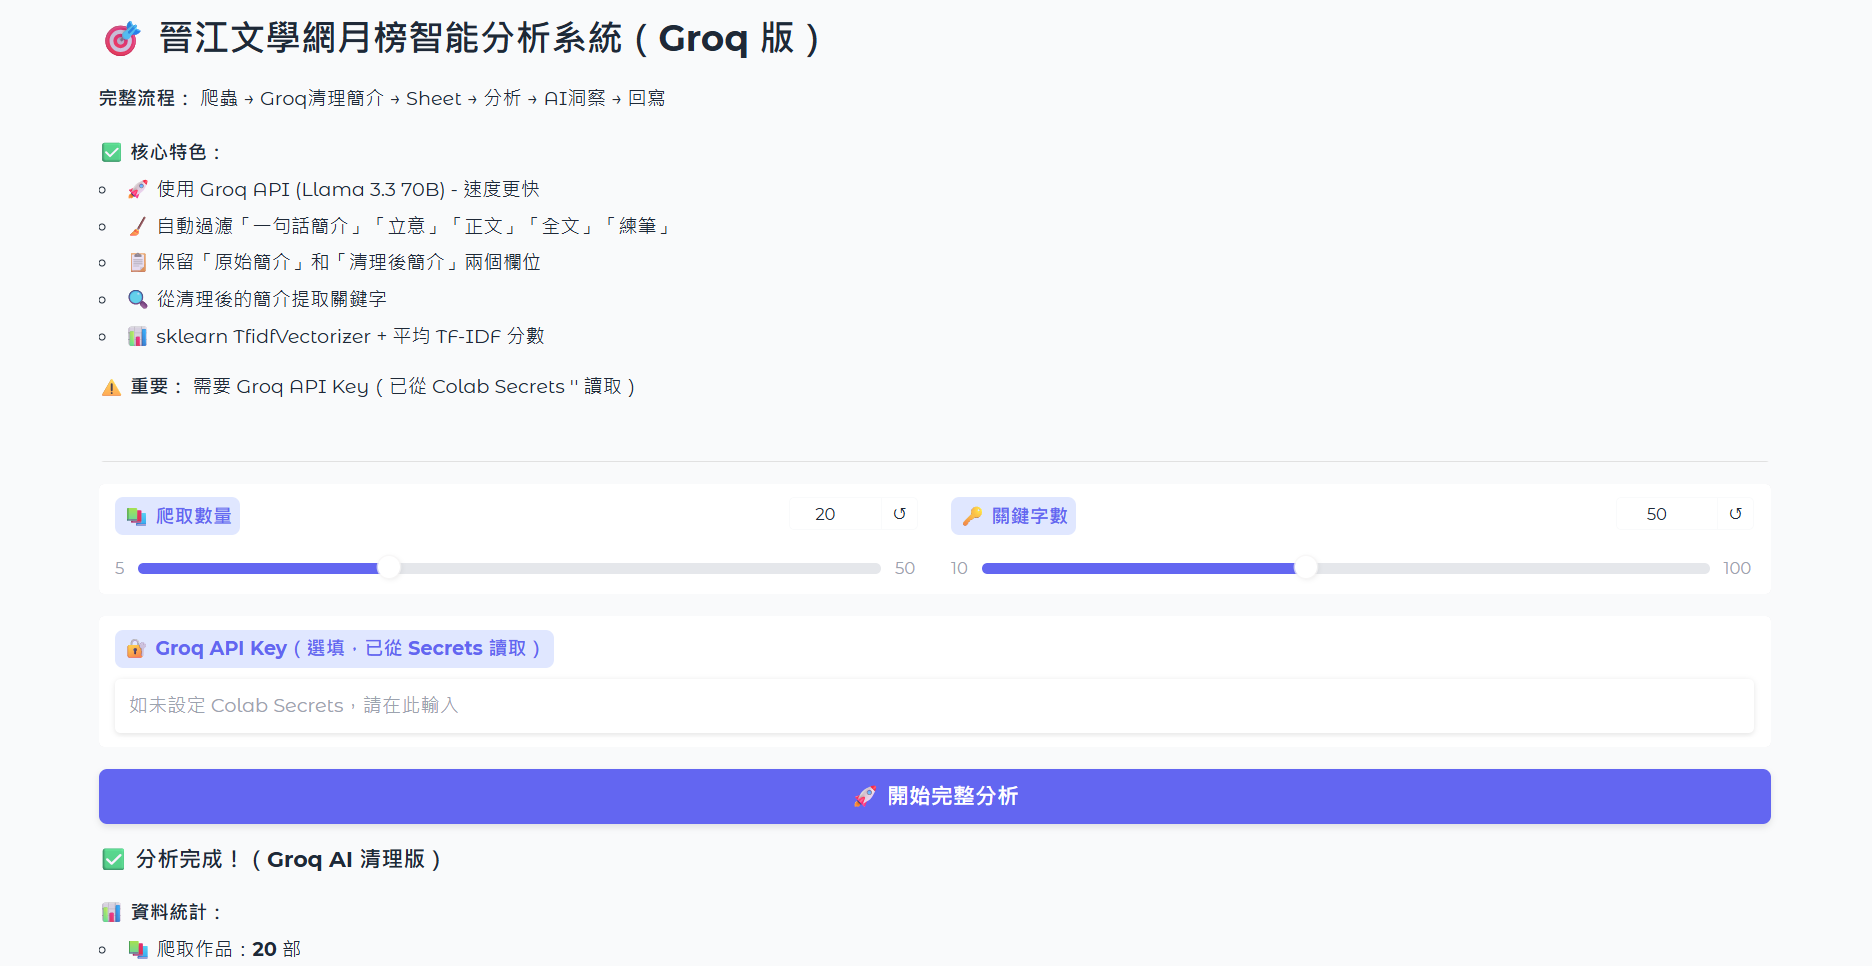

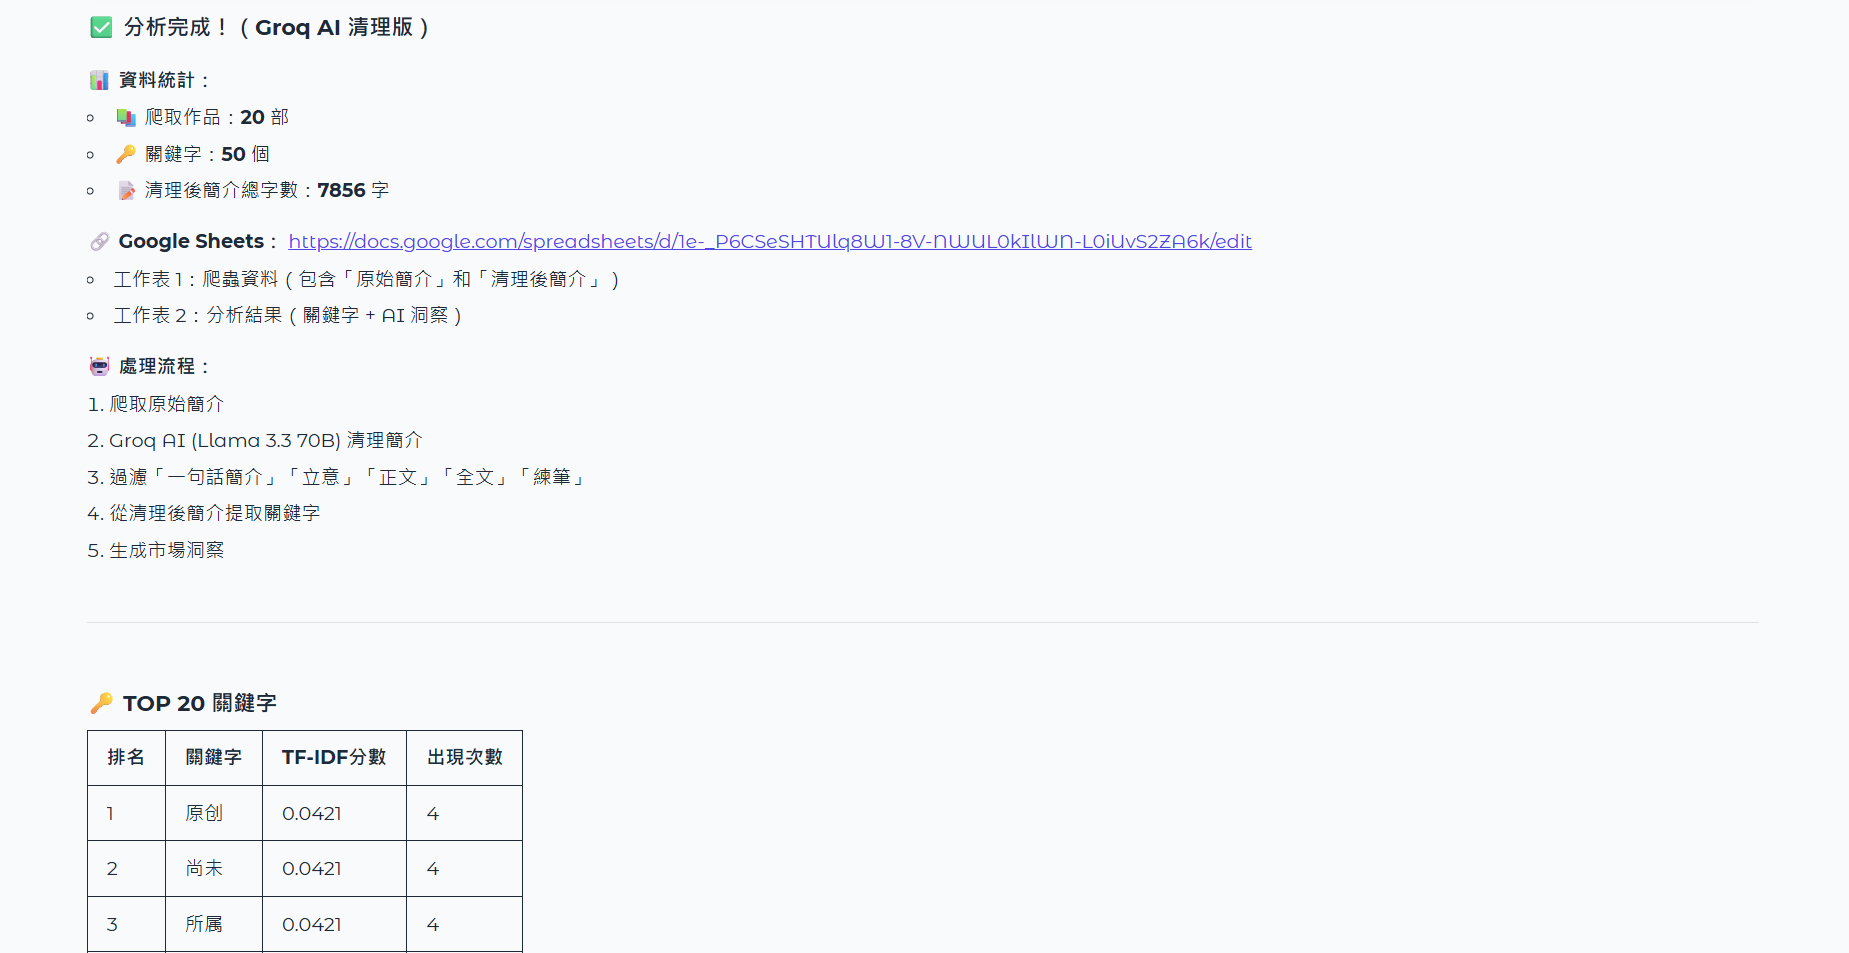

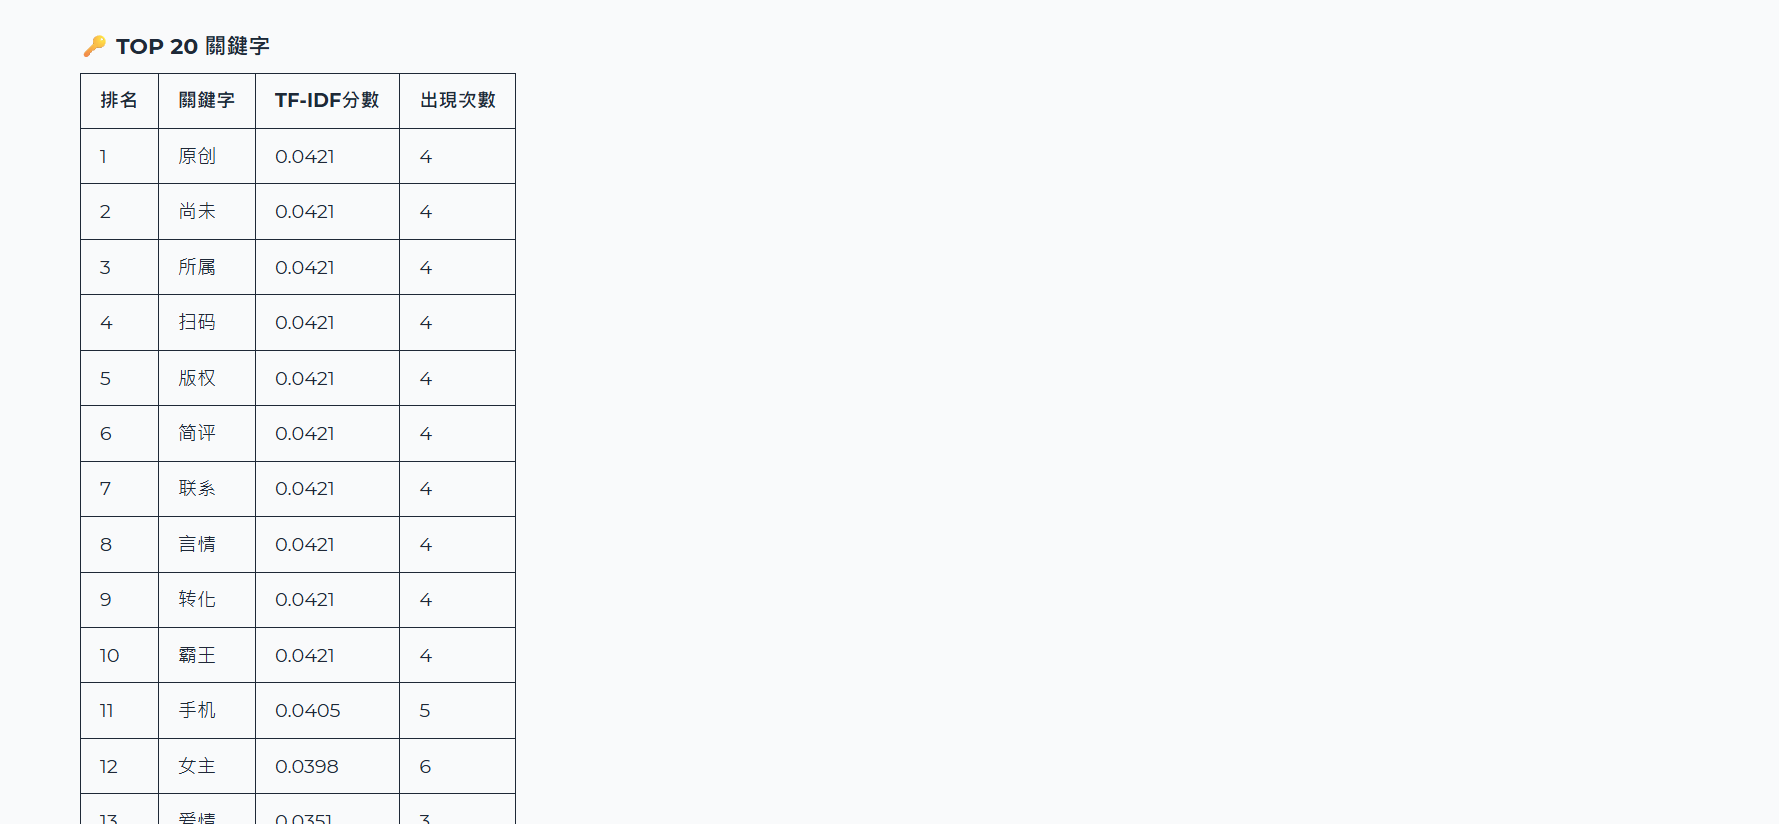

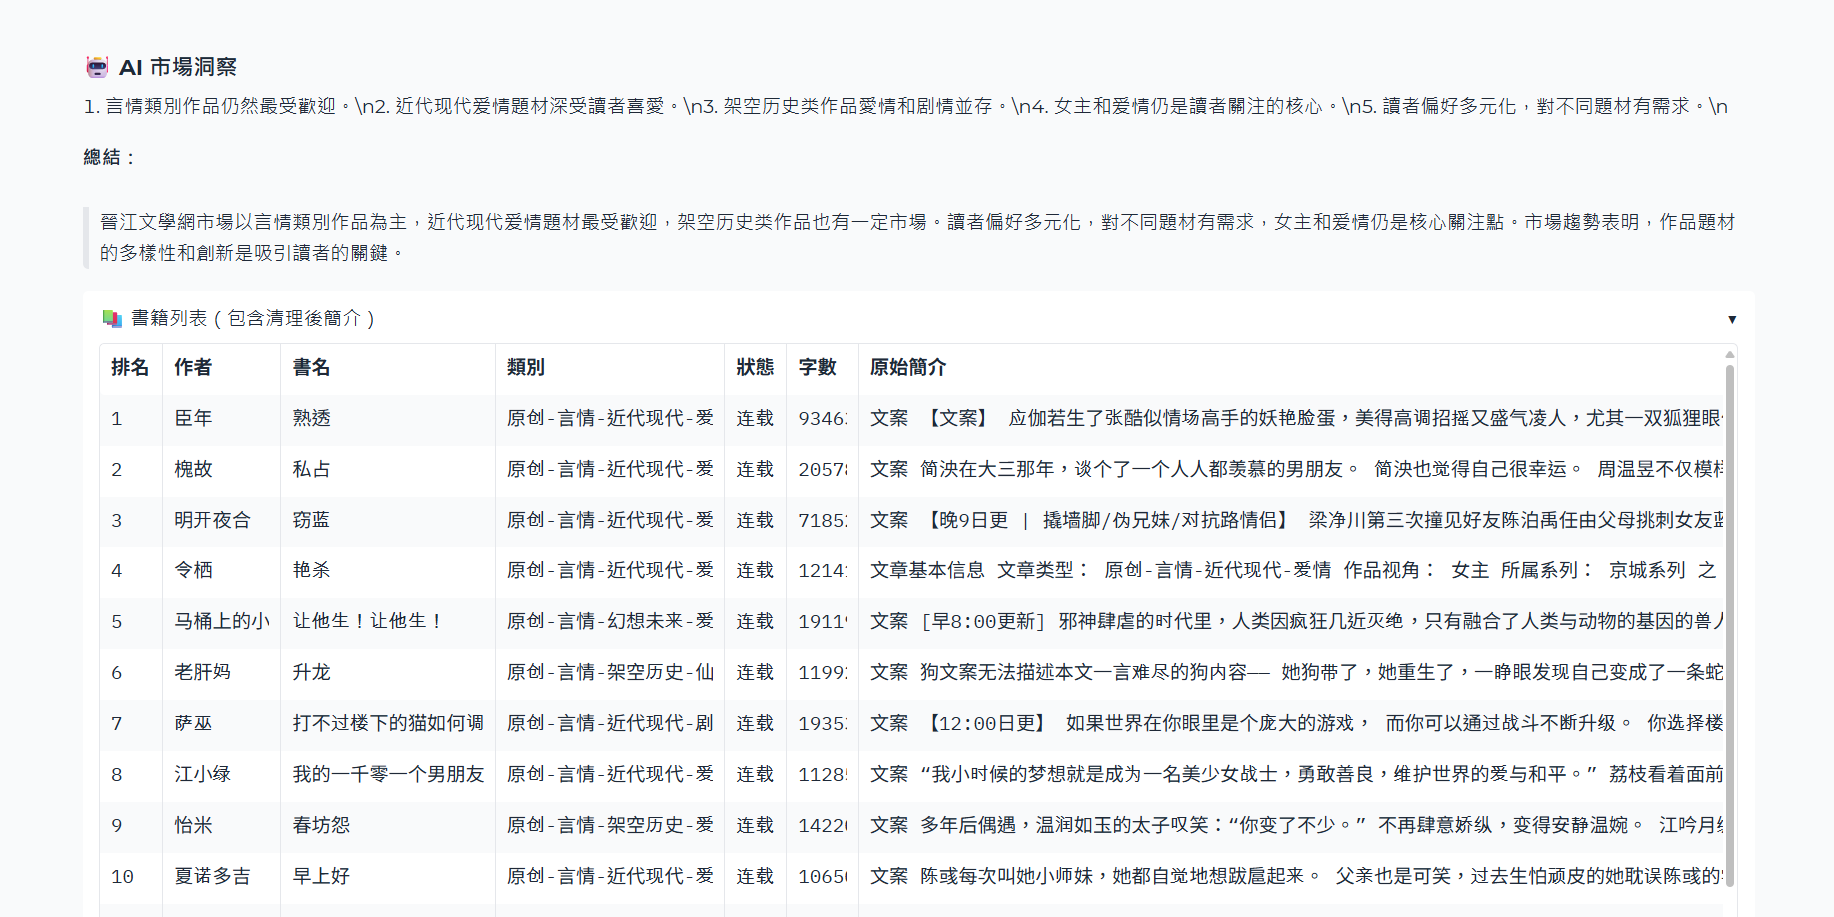

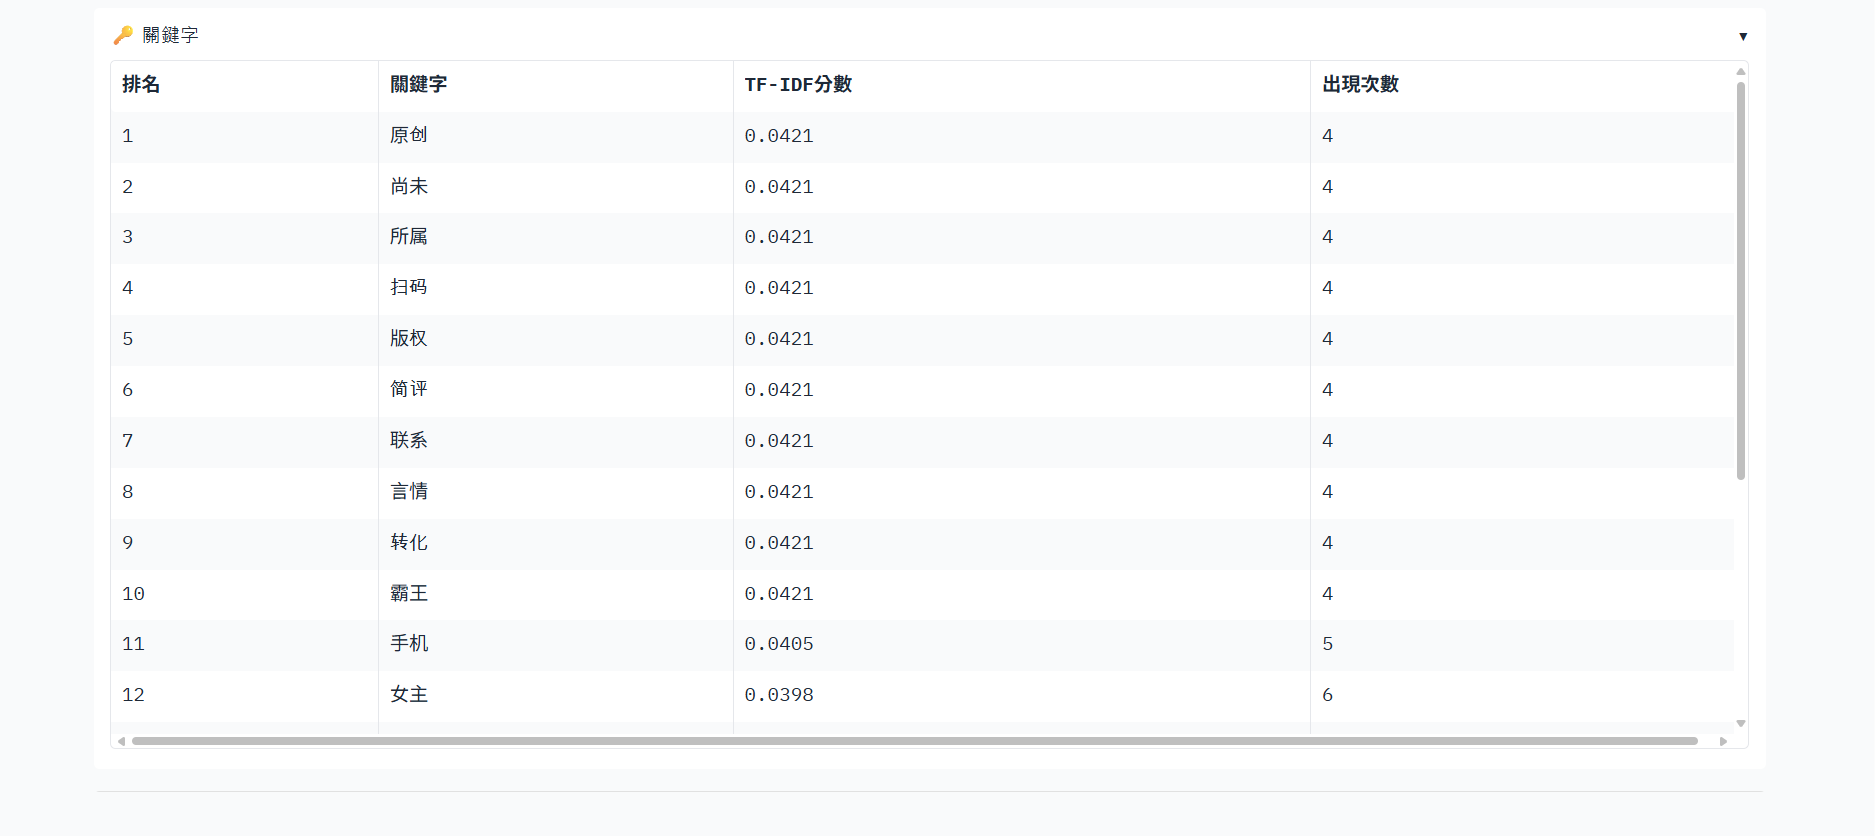

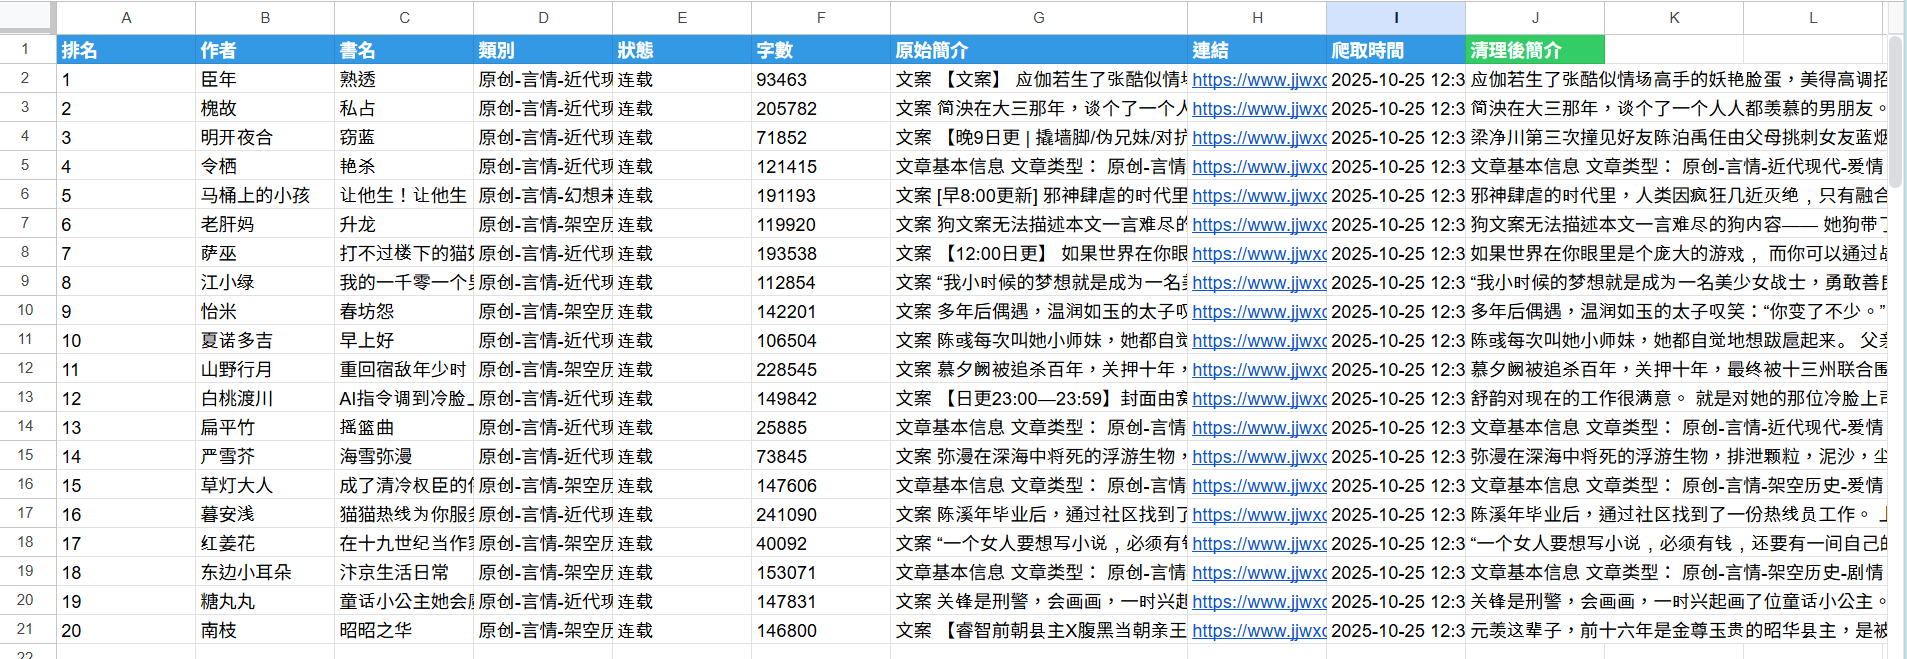

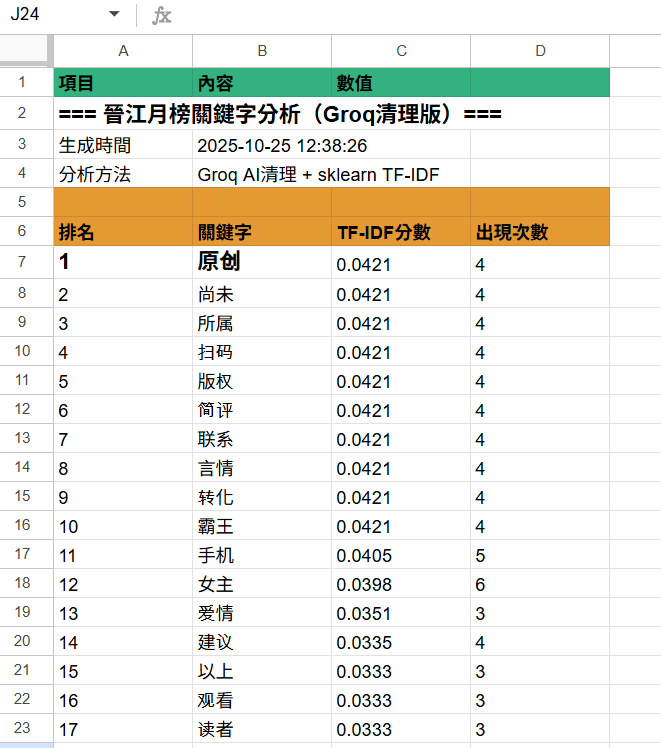